# Toronto Dwellings Analysis Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions to create a Panel dashboard.

In [29]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [30]:
# Initialize the Panel Extensions (for Plotly)
import panel as pn
pn.extension("plotly")

In [31]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [32]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/toronto_neighbourhoods_census_data.csv")
to_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/toronto_neighbourhoods_coordinates.csv")
df_neighbourhood_locations = pd.read_csv(file_path)


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

### Global available data

In [33]:
# Getting the data from the top 10 expensive neighbourhoods
top_10_neighbourhoods = to_data[['neighbourhood','average_house_value']].groupby(['neighbourhood']).mean()
top_10_neighbourhoods = top_10_neighbourhoods.sort_values("average_house_value", ascending=False).nlargest(10, "average_house_value")

# Calculate the mean number of dwelling types units per year
dwelling_types = ["single_detached_house", "apartment_five_storeys_plus", "movable_dwelling", "semi_detached_house", "row_house", "duplex", "apartment_five_storeys_less", "other_house"]
df_dwelling_units = to_data[dwelling_types].groupby(to_data.index).sum()

# Calculate the average monthly shelter costs for owned and rented dwellings
monthly_shelter_costs = (to_data[['shelter_costs_owned', 'shelter_costs_rented']]).groupby('year').mean()



In [35]:
dwelling_types_year = to_data[['single_detached_house',
'apartment_five_storeys_plus',
'movable_dwelling',
'semi_detached_house',
'row_house',
'duplex',
'apartment_five_storeys_less',
'other_house']]

dwelling_types_year = dwelling_types_year.groupby('year').sum()

### Panel Visualization Functions

In [79]:
# Define Panel visualization functions
def neighbourhood_map():
    """Neighbourhood Map"""
    mean_values = to_data[['neighbourhood','average_house_value']].groupby(['neighbourhood']).mean().reset_index()
    avg_locations = pd.concat([mean_values, df_neighbourhood_locations], join='inner', axis='columns')

    plot_neighbourhood = px.scatter_mapbox(
    avg_locations, 
    lat='lat', 
    lon='lon', 
    size='average_house_value',
    color='average_house_value',
    color_continuous_scale=px.colors.cyclical.IceFire,
    title='Average Neighbourhood House Values in Toronto',
    width=1000,
    height=500,
    zoom=9
    )
    plot_neighbourhood = plot_neighbourhood.update_mapboxes(style='open-street-map')
    
    return plot_neighbourhood

def create_bar_chart(data, title, xlabel, ylabel, color):
    """
    Create a barplot based in the data argument.
    """
    
    fig = plt.figure(figsize=(6,5))

    # create a bar plot
    bar_chart = data.plot.bar(color=color)
    bar_chart.set_xlabel(xlabel)
    bar_chart.set_ylabel(ylabel)
    bar_chart.set_title(title, fontweight="bold")
    width=250
    height=500
    plt.show()
    
    return pn.pane.Matplotlib(fig, tight=True)

def create_line_chart(data, title, xlabel, ylabel, color):
    """
    Create a line chart based in the data argument.
    """
    
    fig = plt.figure()
    line_chart = data.plot.line(color=color)
    line_chart.set_title(title, fontweight="bold")
    line_chart.set_xlabel(xlabel)
    line_chart.set_ylabel(ylabel)
    plt.show()
    return fig
    
def average_house_value():
    """Average house values per year."""
    average_house_value = to_data['average_house_value'].groupby('year').mean()
    average_house_value_plt = average_house_value.plot(
    title='Average House Value in Toronto', 
    xlabel = 'Year', 
    ylabel = 'Avg. House Value'
    )
    
    return average_house_value_plt

def average_value_by_neighbourhood():
    """Average house values by neighbourhood."""
    average_house_value = to_data[["neighbourhood", "average_house_value"]].groupby(["neighbourhood",to_data.index]).mean()
    avg_vaule = average_house_value.hvplot.line(
    "year",
    "average_house_value",
    xlabel="Year",
    ylabel="Avg. House Value",
    groupby="neighbourhood",).opts(yformatter = "%.0f", frame_height = 300)
    
    return avg_vaule
    # YOUR CODE HERE!

def number_dwelling_types():
    """Number of dwelling types per year"""
    
    # Fetch the data of all dwelling types per year
    all_dwelling_types = to_data.drop(columns=['average_house_value','shelter_costs_owned','shelter_costs_rented']).groupby(['year','neighbourhood']).mean()
    
    # Use hvplot to create an interactive bar chart of the number of dwelling types per neighbourhood
    # The plot should have a dropdown selector for the neighbourhood
    all_dwelling_types_plt = all_dwelling_types.hvplot.bar(
        x='year',
        groupby="neighbourhood",
        rot=90
    ).opts(frame_height=200)
    
    return all_dwelling_types_plt
    

def average_house_value_snapshot():
    """Average house value for all Toronto's neighbourhoods per year."""
    avg_neighbourhood_values = (to_data[['neighbourhood','average_house_value']]).groupby(['year','neighbourhood']).mean().reset_index()
    facet_bar = px.bar(
    avg_neighbourhood_values, 
    x='neighbourhood', 
    y='average_house_value', 
    color = 'average_house_value', 
    facet_row='year',
        labels={'average_house_value':'Avg. House Value'},
        title= 'Average House Values in Toronto per Neighbourhood',
        width=1000,
        height=1000
    )
    
    return facet_bar

    # YOUR CODE HERE!

def top_most_expensive_neighbourhoods():
    """Top 10 most expensive neighbourhoods."""
    top_10 = top_10_neighbourhoods.hvplot.bar(x="neighbourhood", 
        y='average_house_value', 
        xlabel = "Neighbourhood", 
        ylabel = "Average House Value", 
        rot=90, title = "Top 10 Most Expensive Neighbourhoods").opts(yformatter = "%.0f", frame_height = 300)
    
    return top_10


def sunburts_cost_analysis():
    """Sunburst chart to conduct a costs analysis of most expensive neighbourhoods in Toronto per year."""
    expensive_neighbourhoods = to_data[['neighbourhood','average_house_value']].groupby(['year','neighbourhood']).mean().reset_index()
    years = list(dwelling_types_year.index)
    df=pd.DataFrame()
    
    for year in years:
        year_data = expensive_neighbourhoods[expensive_neighbourhoods["year"] == year]
        data_df = year_data.set_index("neighbourhood").nlargest(n=10, columns=['average_house_value'])
        df = df.append(data_df)
    
    sunburst_df = df.reset_index()
    
    sunburst = px.sunburst(sunburst_df,
                  path=['year', 'neighbourhood'],
                  values='average_house_value',
                  title="Most Expensive Neighbourhoods in Toronto per year",
                  width=750, height=750)
    
    return sunburst

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

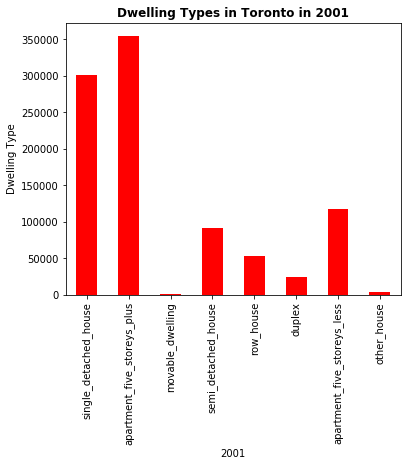

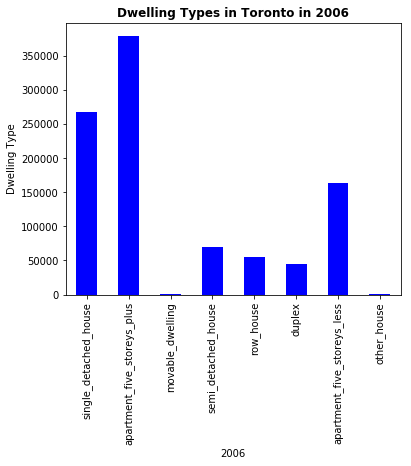

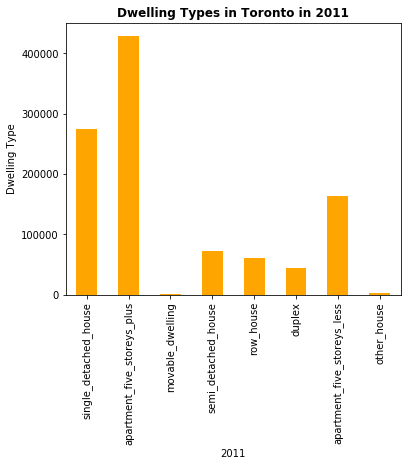

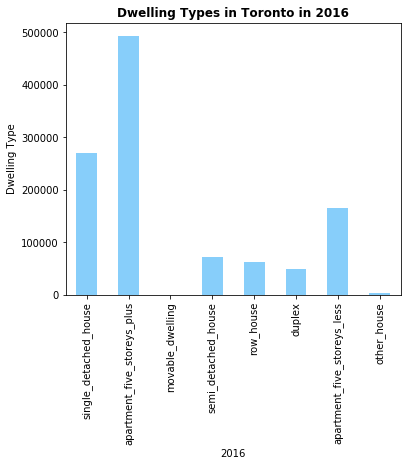

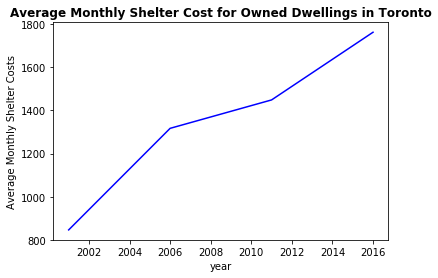

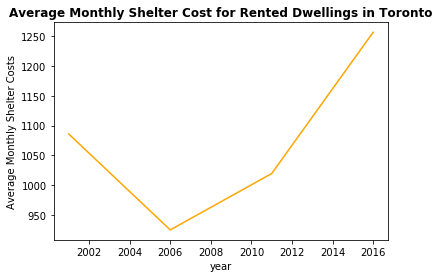

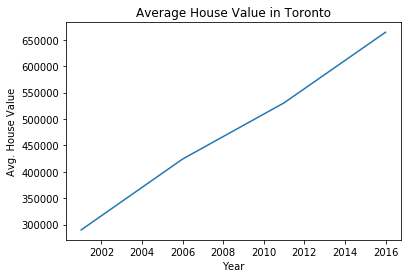

In [80]:
# Create a Title for the Dashboard
title = pn.pane.Markdown(""" ## Real Estate Analysis of Toronto from 2001 to 2016""", width=600)


# Define a welcome text
welcome = pn.pane.Markdown(""" This dashboard displays a visual analysis of historical house values, dwelling types per neighbourhood and dwelling costs in Toronto, Ontario from census data. You can navigate through the above tabs to explore more details about the evolution of the real estate market across the 2001-2016 period. """,
                           width = 1000)


# Create a tab layout for the dashboard
tabs = pn.Tabs(
    # First
    (
        "Welcome",
        pn.Column(
            welcome,
            neighbourhood_map()
        )
    ),
    # Second
    (
        "Yearly Market Analysis",
        pn.Column(
            pn.Row(
                create_bar_chart(
                    dwelling_types_year.loc[2001], 
                    'Dwelling Types in Toronto in 2001', 
                    '2001', 
                    'Dwelling Type', 
                    'red'
                ),
                create_bar_chart(
                    dwelling_types_year.loc[2006], 
                    'Dwelling Types in Toronto in 2006', 
                    '2006', 'Dwelling Type', 
                    'blue'
                ),
            ),
            pn.Row(
                create_bar_chart(
                    dwelling_types_year.loc[2011], 
                    'Dwelling Types in Toronto in 2011',
                    '2011', 'Dwelling Type', 
                    'orange'
                ),
                create_bar_chart(
                    dwelling_types_year.loc[2016], 
                    'Dwelling Types in Toronto in 2016', 
                    '2016', 
                    'Dwelling Type', 
                    'lightskyblue'
                ),
            )

        )
    ),
    # Third
    
    (
        'Shelter Costs Vs. House Value',
        pn.Column(
            create_line_chart(
                monthly_shelter_costs.loc[:,'shelter_costs_owned'],
                'Average Monthly Shelter Cost for Owned Dwellings in Toronto', 
                'year', 
                'Average Monthly Shelter Costs', 
                'blue'
            ),
            create_line_chart(
                monthly_shelter_costs.loc[:,'shelter_costs_rented'],
                'Average Monthly Shelter Cost for Rented Dwellings in Toronto', 
                'year', 
                'Average Monthly Shelter Costs', 
                'orange'
            ),
            average_house_value()
        )
    ),
    # Forth
    (
        "Neighbourhood Analysis",
        pn.Row(
            pn.Column(
                average_value_by_neighbourhood(),
                number_dwelling_types(),
            ),
            pn.Column(
                average_house_value_snapshot(),
            )
        )
    ),
    # Fifth tab
    (
        "Top Expensive Neighbourhoods",
        pn.Row(
            top_most_expensive_neighbourhoods(),
            sunburts_cost_analysis(),
        )
    )
)


# Create the main dashboard
dashboard =pn.Column(
    pn.Row(title),
    tabs,
    width=1024,
    height=768
)


## Serve the Panel Dashboard

Column(height=768, sizing_mode='fixed', width=1024)
    [0] Row
        [0] Markdown(str, width=600)
    [1] Tabs
        [0] Column
            [0] Markdown(str, width=1000)
            [1] Plotly(Figure)
        [1] Column
            [0] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
            [1] Row
                [0] Matplotlib(Figure, tight=True)
                [1] Matplotlib(Figure, tight=True)
        [2] Column
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
            [2] Str(AxesSubplot)
        [3] Row
            [0] Column
                [0] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
                [1] Row
                    [0] HoloViews(DynamicMap)
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighbourhood', options=['Agincourt North', ...], value='Agincourt North', width=250)
                        [1] VSpacer()
            [1] Column
                [0] Plotly(Figure)
        [4] Row
            [0] HoloViews(Bars)
            [1] Plotly(Figure)
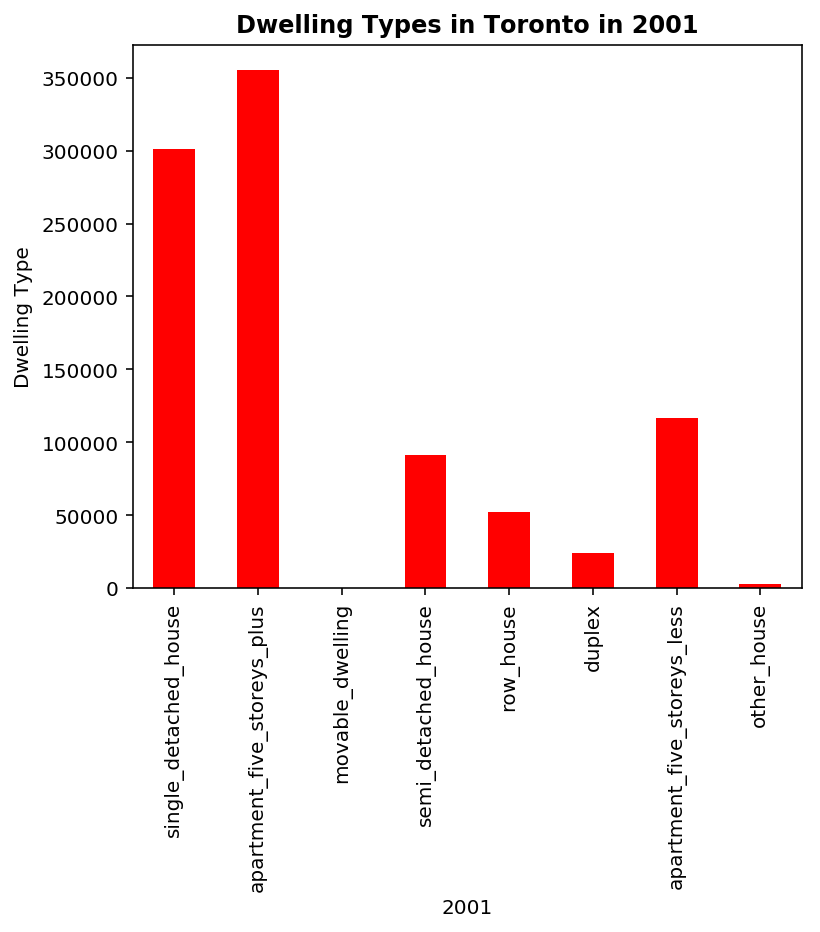
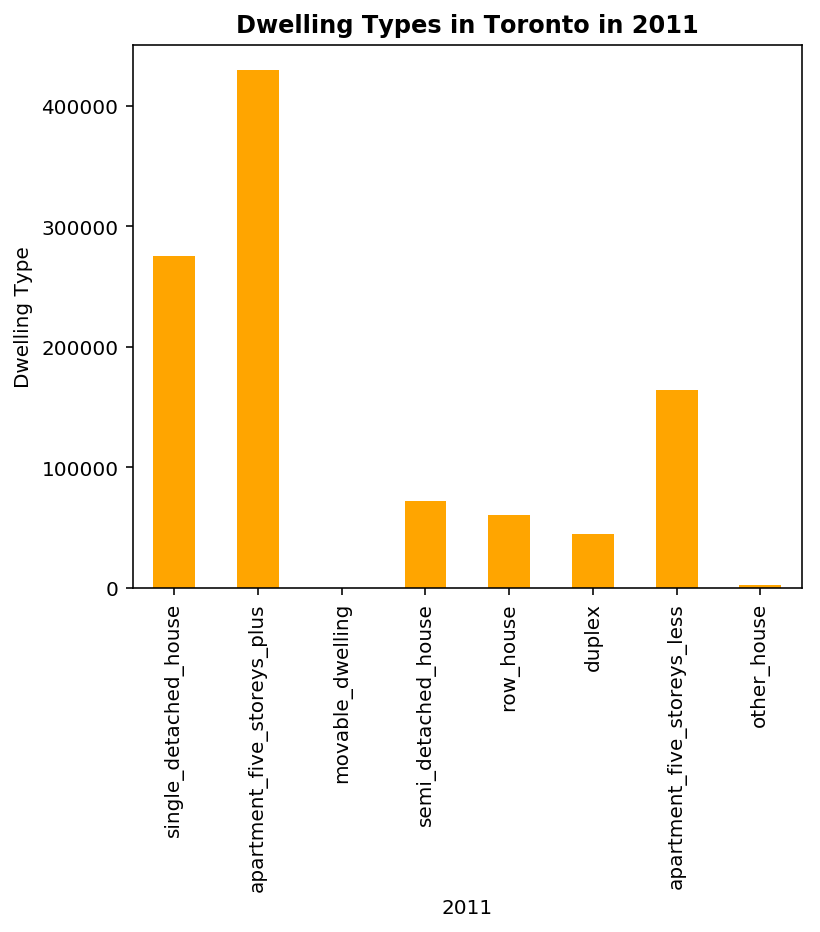
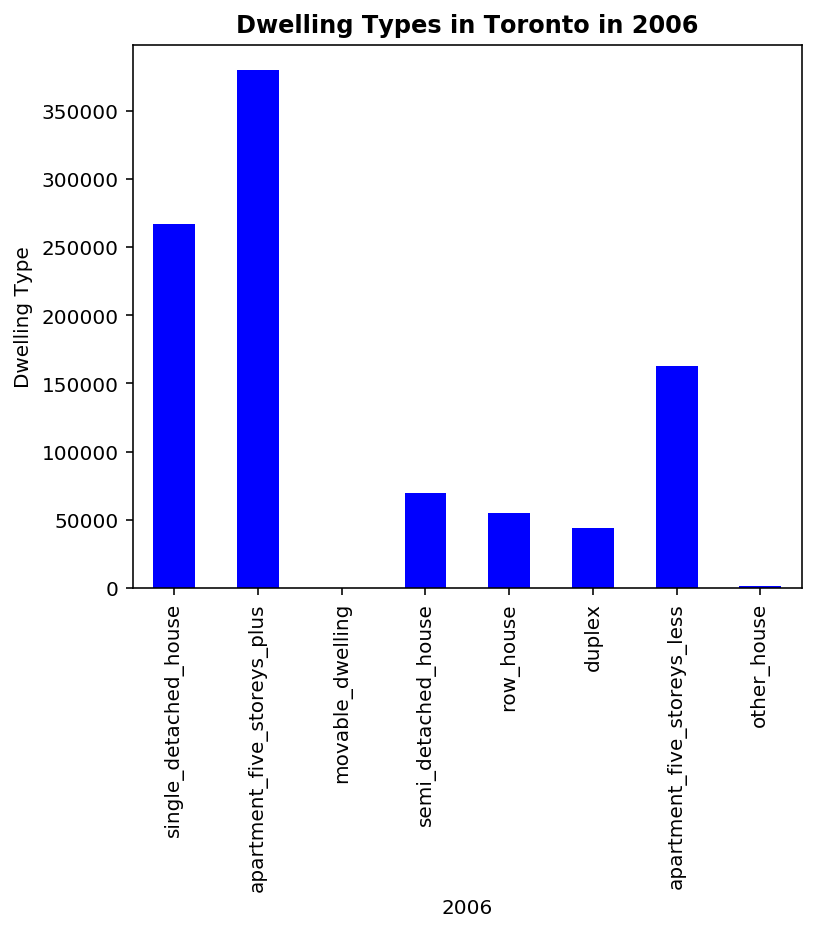
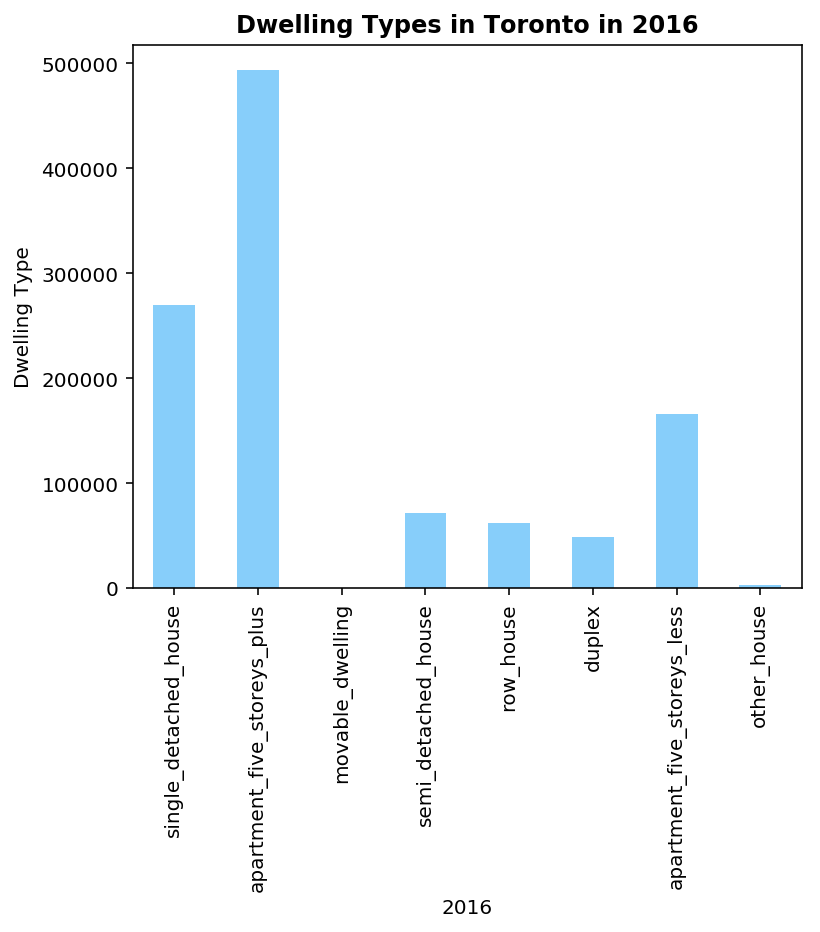
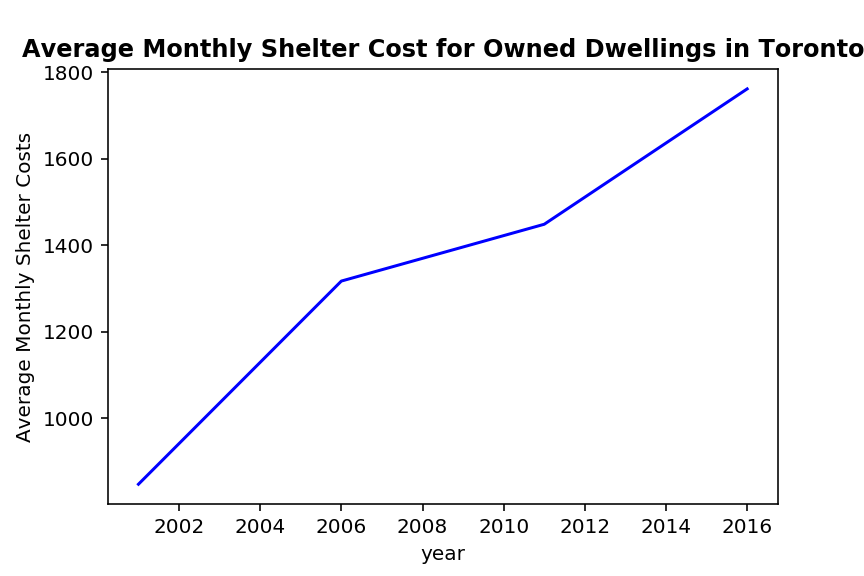
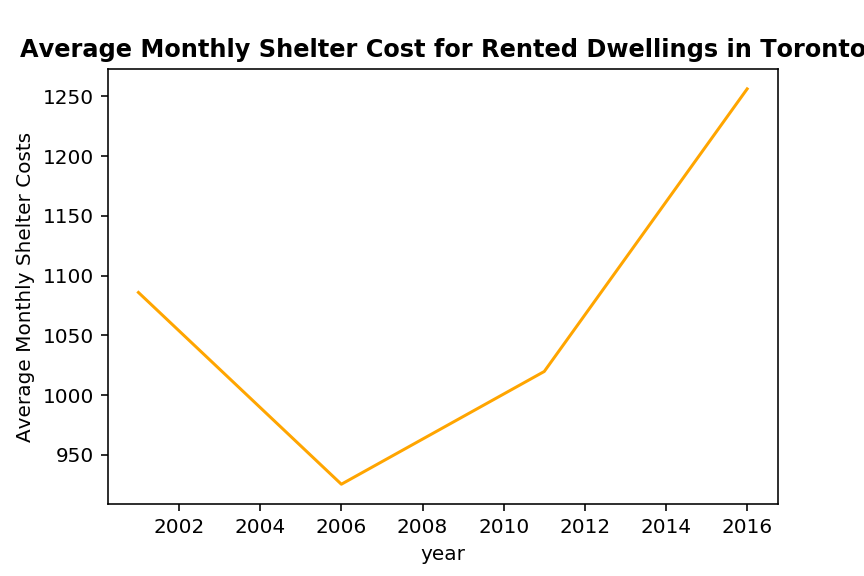

In [81]:
dashboard.servable()

In [82]:
pn.serve(dashboard)

Launching server at http://localhost:60628


# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [67]:
# neighbourhood_map().show()

In [68]:
# create_bar_chart(data, title, xlabel, ylabel, color)

# # Bar chart for 2001
# create_bar_chart(df_dwelling_units.loc[2001], "Dwelling Types in Toronto in 2001", "2001", "Dwelling Type Units", "red")

# # Bar chart for 2006
# create_bar_chart(df_dwelling_units.loc[2006], "Dwelling Types in Toronto in 2006", "2006", "Dwelling Type Units", "blue")

# # Bar chart for 2011
# create_bar_chart(df_dwelling_units.loc[2011], "Dwelling Types in Toronto in 2011", "2011", "Dwelling Type Units", "orange")

# # Bar chart for 2016
# create_bar_chart(df_dwelling_units.loc[2016], "Dwelling Types in Toronto in 2016", "2016", "Dwelling Type Units", "magenta")

In [ ]:
# create_line_chart(data, title, xlabel, ylabel, color)

# # Line chart for owned dwellings
# create_line_chart(df_avg_costs["shelter_costs_owned"], "Average Monthly Shelter Cost for Owned Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "blue")

# # Line chart for rented dwellings
# create_line_chart(df_avg_costs["shelter_costs_rented"], "Average Monthly Shelter Cost for Rented Dwellings in Toronto", "Year", "Avg Monthly Shelter Costs", "orange")

In [70]:
# average_house_value()

In [ ]:
# average_value_by_neighbourhood()

In [ ]:
# number_dwelling_types()

In [ ]:
# average_house_value_snapshot()

In [ ]:
# top_most_expensive_neighbourhoods()

In [ ]:
# sunburts_cost_analysis()